In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import zscore
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

**3. How closely does lateness (ADHERENCE) correlate to headway?**

Independent variable belongs on the x-axis and dependent variable belongs on the y-axis.

- Target/ dependent variable (variable you're trying to predict) - headway deviation.
- Predictor/ independent variable (variable you use to make prediction) - adherence. 

Reminder that: 
- ADHERENCE: Difference between actual departure time and scheduled time; negative indicates departure time after scheduled time and positive indicates departure time before scheduled time.
- HDWY_DEV: calculates headway deviation in minutes as the difference between actual and scheduled headway. Negative values indicate a shorter headway than scheduled (i.e. bunching) and positive values indicate a longer headway than scheduled (i.e. gapping). 

In [2]:
headway_data = pd.read_csv("../data/headway_data.csv", delimiter = '\t')
headway_data.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,-0.144444
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,-0.258889


**Correlation Coefficient**

In [3]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(headway_data['ADHERENCE'], headway_data['HDWY_DEV'])

# Print the correlation coefficient
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Pearson Correlation Coefficient: -0.20682243927838445


There seems to be a weak inverse relationship between ADHERENCE (amount of time was early or behind departure schedule) and HDWY_DEV (amount of time you wait at a stop in between buses). The negative means that as one variable increases, the other tends to decrease and vice versa. 

**Scatter Plots** 

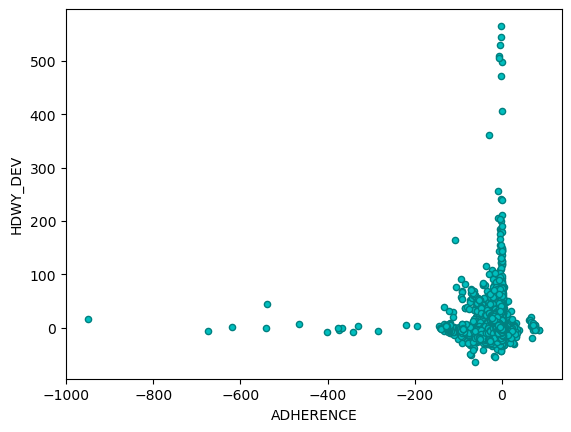

In [4]:
headway_data.plot.scatter(x = 'ADHERENCE', y = 'HDWY_DEV', s = 20, color = 'c', edgecolor = 'teal', linewidth=1); #cyan

In [5]:
# Filter the DataFrame for positive and neutral adherence values
positive_adherence = headway_data[headway_data['ADHERENCE'] > 1]
neutral_adherence = headway_data[(headway_data['ADHERENCE'] > -1) & (headway_data['ADHERENCE'] < 1)]
negative_adherence = headway_data[headway_data['ADHERENCE'] < -1]

# Calculate statistics for both subsets
positive_stats = positive_adherence['HDWY_DEV'].describe()
neutral_stats = neutral_adherence['HDWY_DEV'].describe()
negative_stats = negative_adherence['HDWY_DEV'].describe()

# Create a DataFrame with the combined statistics
adherence_stats = pd.DataFrame({
    'Adherence Type': ['Positive', 'Neutral', 'Negative'],
    'Count': [positive_stats['count'], neutral_stats['count'], negative_stats['count']],
    'Mean': [positive_stats['mean'], neutral_stats['mean'], negative_stats['mean']],
    'Std': [positive_stats['std'], neutral_stats['std'], negative_stats['std']],
    'Min': [positive_stats['min'], neutral_stats['min'], negative_stats['min']],
    '25%': [positive_stats['25%'], neutral_stats['25%'], negative_stats['25%']],
    '50%': [positive_stats['50%'], neutral_stats['50%'], negative_stats['50%']],
    '75%': [positive_stats['75%'], neutral_stats['75%'], negative_stats['75%']],
    'Max': [positive_stats['max'], neutral_stats['max'], negative_stats['max']]
})

# Display the DataFrame
adherence_stats

,Adherence Type,Count,Mean,Std,Min,25%,50%,75%,Max
0,Positive,8819.0,-3.695143,5.446979,-33.150000,-5.966667,-3.483334,-1.750000,78.050000
1,Neutral,72111.0,-1.677035,5.946462,-32.866667,-3.550000,-1.483334,-0.100000,498.066666
2,Negative,183992.0,1.590440,7.396909,-64.000000,-1.200000,1.166666,3.633333,565.433333


This table shows that: 
- When the bus leaves before the scheduled departure time (positive ADHERENCE), the average time in minutes between the actual and scheduled headway (HDWY_DEV) is about 4 minutes shorter (negative HDWY_DEV). 
- When the bus leaves about on time (neutral adherence), the avg waiting time between buses decreases by about a min and a half (neg HDWY_DEV). 
- When the bus leaves after the scheduled departure time (negative ADHERENCE), the avg waiting time increases to a minute and a half (neutral HDWY_DEV). 

**Linear Regression Model**

lm = smf.ols('target variable ~ predictor variable', data = df).fit()

lm.summary()

In [6]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = headway_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                 1.188e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:34:42   Log-Likelihood:            -8.9492e+05
No. Observations:              265884   AIC:                         1.790e+06
Df Residuals:                  265882   BIC:                         1.790e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2802      0.015    -18.151      0.000      -0.310      -0.250
ADHERENCE     -0.2279      0.002   -109.002      0.000      -0.232      -0.224
==============================================================================
Omnibus:                   525134.358   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       9643452394.096
Skew:                          15.113   Prob(JB):                         0.00
Kurtosis:                     935.498   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.

For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to change by approximately -0.2279 minutes (or about 13.7 seconds) . The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scehduled time), 'HDWY_DEV' is expected to decrease (become more negative).

**Goal:** Use the new data to re-do analysis and to answer the question above. 

In [7]:
processed_data = pd.read_csv('../data/processed_data.csv')
processed_data.head(3)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.000000,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.000000,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,63,13.216666,0.076190,0.300000,0.274867,120230801_345106,-1.916666,NaN


**Correlation Coefficient**

In [8]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(processed_data['ADHERENCE'], processed_data['HDWY_DEV'])

# Print the correlation coefficient
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Pearson Correlation Coefficient: -0.4390532413991298


There is a stronger negative correlation than from the original data (-0.20682243927838445). 

**Scatter Plots** 

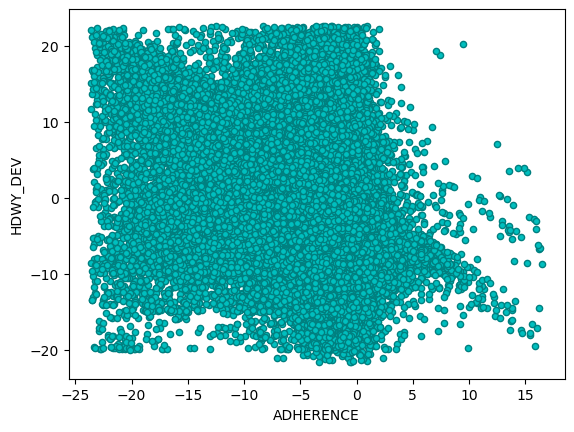

In [9]:
processed_data.plot.scatter(x = 'ADHERENCE', y = 'HDWY_DEV', s = 20, color = 'c', edgecolor = 'teal', linewidth=1); #cyan

No apparent relationship between the two variables. 

**Question:** How does classification of the adherence affect headway deviation? 

In [10]:
# Filter the DataFrame for positive and neutral adherence values
positive_adherence = processed_data[processed_data['ADHERENCE'] > 1]
neutral_adherence = processed_data[(processed_data['ADHERENCE'] > -1) & (processed_data['ADHERENCE'] < 1)]
negative_adherence = processed_data[processed_data['ADHERENCE'] < -1]

# Calculate statistics for both subsets
positive_stats = positive_adherence['HDWY_DEV'].describe()
neutral_stats = neutral_adherence['HDWY_DEV'].describe()
negative_stats = negative_adherence['HDWY_DEV'].describe()

# Create a DataFrame with the combined statistics
adherence_stats = pd.DataFrame({
    'Adherence Type': ['Positive', 'Neutral', 'Negative'],
    'Count': [positive_stats['count'], neutral_stats['count'], negative_stats['count']],
    'Mean': [positive_stats['mean'], neutral_stats['mean'], negative_stats['mean']],
    'Std': [positive_stats['std'], neutral_stats['std'], negative_stats['std']],
    'Min': [positive_stats['min'], neutral_stats['min'], negative_stats['min']],
    '25%': [positive_stats['25%'], neutral_stats['25%'], negative_stats['25%']],
    '50%': [positive_stats['50%'], neutral_stats['50%'], negative_stats['50%']],
    '75%': [positive_stats['75%'], neutral_stats['75%'], negative_stats['75%']],
    'Max': [positive_stats['max'], neutral_stats['max'], negative_stats['max']]
})

# Display the DataFrame
adherence_stats

,Adherence Type,Count,Mean,Std,Min,25%,50%,75%,Max
0,Positive,8460.0,-3.867516,4.089215,-21.083334,-5.937501,-3.491667,-1.783334,22.266666
1,Neutral,70223.0,-1.955227,3.627858,-21.600000,-3.550000,-1.500000,-0.133334,22.633333
2,Negative,174672.0,1.189760,4.851683,-21.583334,-1.166667,1.133333,3.466666,22.633333


This table shows that: 
- When the bus leaves before the scheduled departure time (positive ADHERENCE), the average time in minutes between the actual and scheduled headway (HDWY_DEV) is about 4 minutes shorter (negative HDWY_DEV). 
- When the bus leaves about on time (neutral adherence), the avg waiting time between buses decreases by about a min and a half (neg HDWY_DEV). 
- When the bus leaves after the scheduled departure time (negative ADHERENCE), the avg waiting time increases to a minute and a half (neutral HDWY_DEV). 

*This reflects about the same observation from the original data without the removal of outliers.*

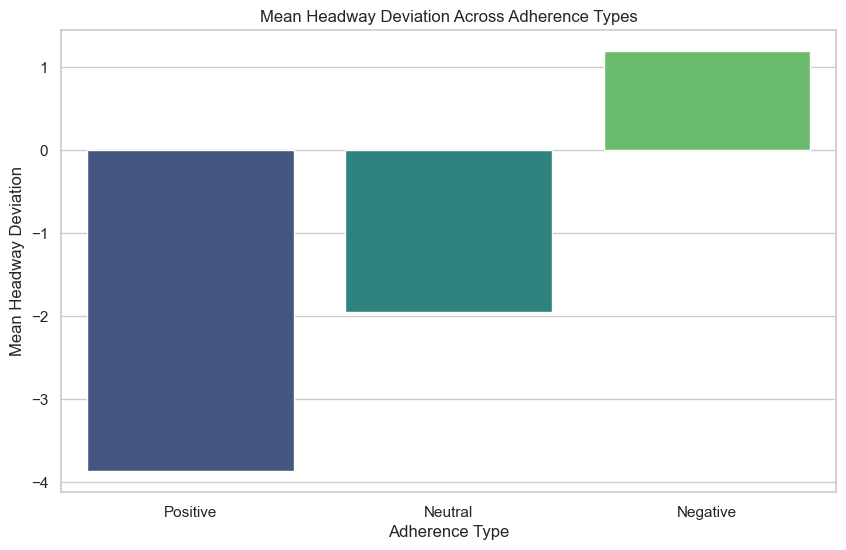

In [11]:
sns.set(style="whitegrid")

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Adherence Type', y='Mean', data=adherence_stats, palette='viridis')
plt.title('Mean Headway Deviation Across Adherence Types')
plt.xlabel('Adherence Type')
plt.ylabel('Mean Headway Deviation')
plt.show()

In [12]:
# Step 1: Create a new column 'Adherence_Type'
processed_data['Adherence_Type'] = np.select(
    [processed_data['ADHERENCE'] > 1, (processed_data['ADHERENCE'] > -1) & (processed_data['ADHERENCE'] < 1), processed_data['ADHERENCE'] < -1],
    ['Positive', 'Neutral', 'Negative'],
    default='Unknown'
)

# Step 2: Perform a linear regression using smf
model = smf.ols('HDWY_DEV ~ C(Adherence_Type, Treatment("Neutral"))', data=processed_data).fit()

# Display the regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:34:47   Log-Likelihood:            -7.4429e+05
No. Observations:              254299   AIC:                         1.489e+06
Df Residuals:                  254295   BIC:                         1.489e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -1.9552      0.017   -114.702      0.000      -1.989      -1.922
C(Adherence_Type, Treatment("Neutral"))[T.Negative]     3.1450      0.020    155.817      0.000       3.105       3.185
C(Adherence_Type, Treatment("Neutral"))[T.Positive]    -1.9123      0.052    -36.785      0.000      -2.014      -1.810
C(Adherence_Type, Treatment("Neutral"))[T.Unknown]      0.1933      0.148      1.306      0.192      -0.097       0.483
==============================================================================
Omnibus:                    22041.523   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117646.910
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                       6.296   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- Intercept: Estimated mean of HDWY_DEV when Adherence_Type is "Neutral": -1.96
- Coefficients for Adherence Types (Compared to "Neutral"):
    - Negative: Increase of 3.15 in mean HDWY_DEV
    - Positive: Decrease of 1.91 in mean HDWY_DEV
    - Unknown: Increase of 0.19 in mean HDWY_DEV
- With an R2 of 0.110, this model only explains for about 11% of the variance in HDWY_DEV. 

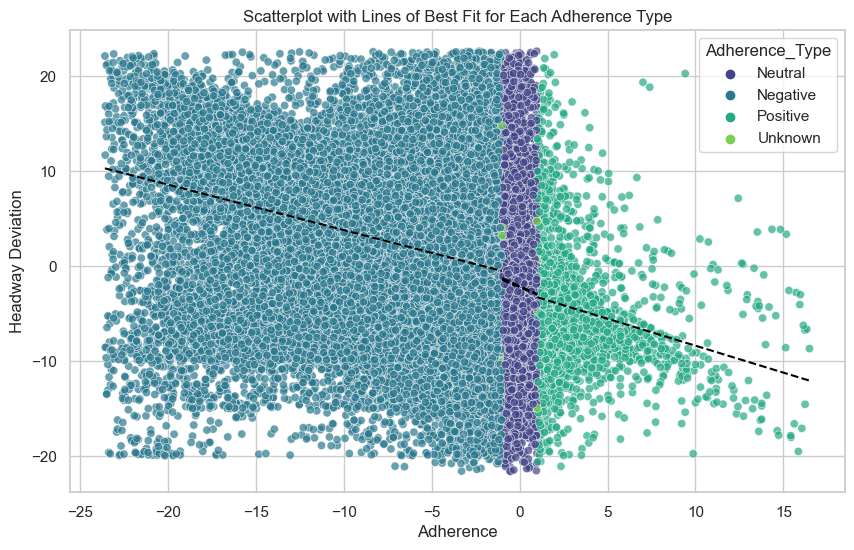

In [13]:
# Set up the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ADHERENCE', y='HDWY_DEV', hue='Adherence_Type', data=processed_data, palette='viridis', alpha=0.7)

# Fit a line of best fit for each adherence type
for adherence_type in processed_data['Adherence_Type'].unique():
    subset = processed_data[processed_data['Adherence_Type'] == adherence_type]
    
    # Fit a linear regression model
    model = sm.OLS(subset['HDWY_DEV'], sm.add_constant(subset['ADHERENCE'])).fit()
    
    # Generate x values for the line
    x_values = np.linspace(subset['ADHERENCE'].min(), subset['ADHERENCE'].max(), 100)
    
    # Calculate y values based on the regression model
    y_values = model.predict(sm.add_constant(x_values))
    
    # Plot the line of best fit with black color
    plt.plot(x_values, y_values, linestyle='--', color='black')

plt.xlabel('Adherence')
plt.ylabel('Headway Deviation')
plt.title('Scatterplot with Lines of Best Fit for Each Adherence Type')
plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/scatterplot_adherencetype.png')
plt.show()

Note: This code analyzes the influence of the adherence type on headway deviation *without setting NEUTRAL as the reference scale*

In [14]:
# Step 1: Create a new column 'Adherence_Type'
processed_data['Adherence_Type'] = np.select(
    [processed_data['ADHERENCE'] > 1, (processed_data['ADHERENCE'] > -1) & (processed_data['ADHERENCE'] < 1), processed_data['ADHERENCE'] < -1],
    ['Positive', 'Neutral', 'Negative'],
    default='Unknown'
)

# Step 2: Perform a linear regression using smf
model = smf.ols('HDWY_DEV ~ C(Adherence_Type)', data=processed_data).fit()

# Display the regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:35:11   Log-Likelihood:            -7.4429e+05
No. Observations:              254299   AIC:                         1.489e+06
Df Residuals:                  254295   BIC:                         1.489e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.1898      0.011    110.080      0.000       1.169       1.211
C(Adherence_Type)[T.Neutral]     -3.1450      0.020   -155.817      0.000      -3.185      -3.105
C(Adherence_Type)[T.Positive]    -5.0573      0.050   -100.570      0.000      -5.156      -4.959
C(Adherence_Type)[T.Unknown]     -2.9517      0.147    -20.023      0.000      -3.241      -2.663
==============================================================================
Omnibus:                    22041.523   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117646.910
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                       6.296   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Linear Regression Model**

lm = smf.ols('target variable ~ predictor variable', data = df).fit()

lm.summary()

In [25]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                 6.073e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:39:57   Log-Likelihood:            -7.3185e+05
No. Observations:              254299   AIC:                         1.464e+06
Df Residuals:                  254297   BIC:                         1.464e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6159      0.011   -145.315      0.000      -1.638      -1.594
ADHERENCE     -0.5678      0.002   -246.427      0.000      -0.572      -0.563
==============================================================================
Omnibus:                    40022.024   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           317317.174
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                       8.367   Cond. No.                         6.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- The F-statistic is a test statistic used to assess the overall significance of the model. The F-statistic is 6.073e+04, and the p-value is 0.00, indicating that the model is statistically significant.
- The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.
- Both coefficients have very low p-values (close to 0), indicating that they are **statistically significant**.
- R-squared of 0.193, indicate that approximately 19.3% of the variance in HDWY_DEV is explained by the model.

mean(ADHERENCE) = -1.6159 - 0.5678(HDWY_DEV)

- For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to decrease by approximately -0.5678 minutes (or about 34 seconds). The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scheduled time), 'HDWY_DEV' is expected to decrease (become more negative).

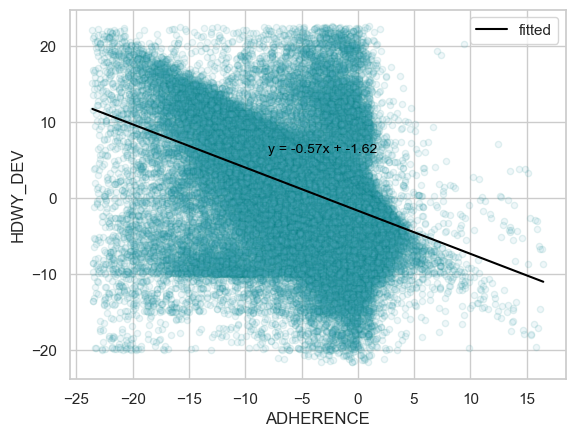

In [39]:
# Variables for y=mx+b equation 
m = lm.params['ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'ADHERENCE', y = 'HDWY_DEV', kind = 'scatter', s = 20, 
                         color = 'c', edgecolor = 'teal', linewidth=1, alpha=0.05); #cyan

# Placement for equation text
ax.text(
    -8, 6, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'ADHERENCE': np.linspace(
        start = processed_data['ADHERENCE'].min(),
        stop = processed_data['ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');
plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/adherence_vs_hdwydev.png')

**Question:** How does adherence at the current stop affects the adherence at the next stop? For a specific trip and day

In [18]:
# Sort data by 'UNIQUE_TRIP_ID' and 'ROUTE_STOP_SEQUENCE' within each trip
processed_data.sort_values(by=['UNIQUE_TRIP_ID', 'ROUTE_STOP_SEQUENCE'], inplace=True)

# Calculate lagged adherence values for each stop
processed_data['PREVIOUS_ADHERENCE'] = processed_data.groupby('UNIQUE_TRIP_ID')['ADHERENCE'].shift(1)
processed_data['NEXT_ADHERENCE'] = processed_data.groupby('UNIQUE_TRIP_ID')['ADHERENCE'].shift(-1)

# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data.loc[processed_data['ROUTE_STOP_SEQUENCE'] == 1]['ADHERENCE'].corr(processed_data['NEXT_ADHERENCE'])
print("Correlation between first stop adherence and next stop adherence:", correlation)

Correlation between first stop adherence and next stop adherence: 0.6822701885119336


In [19]:
lm = smf.ols('NEXT_ADHERENCE ~ PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.256e+05
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:37:16   Log-Likelihood:            -3.1772e+05
No. Observations:              130280   AIC:                         6.355e+05
Df Residuals:                  130278   BIC:                         6.355e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.9873      0.010    -97.255      0.000      -1.007      -0.967
PREVIOUS_ADHERENCE     0.7467      0.002    354.337      0.000       0.743       0.751
==============================================================================
Omnibus:                    34921.944   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           261722.936
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       9.593   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- R-squared (0.491) explains about 49.1% of the variance in 'NEXT_ADHERENCE'.
- The F-statistic is very large (1.256e+05), and the associated p-value (Prob (F-statistic)) is 0.00, which suggests that the model as a whole is **statistically significant.**

mean(PREVIOUS_ADHERENCE) = -0.9873 + .7467(PREVIOUS_ADHERENCE) 

- For every one-unit increase in 'PREVIOUS_ADHERENCE', the 'NEXT_ADHERENCE' is expected to increase by approximately 0.7647 units (about 45 seconds). 

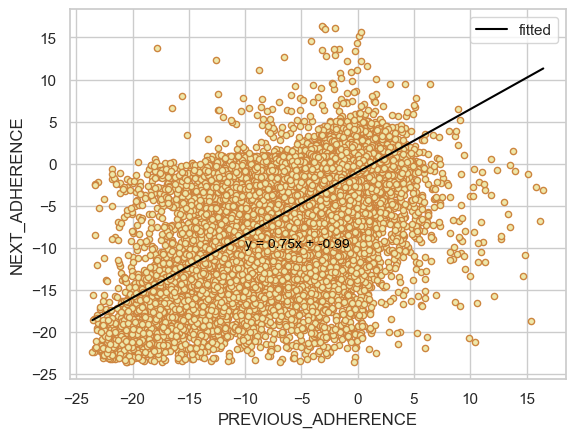

In [20]:
# Variables for y=mx+b equation 
m = lm.params['PREVIOUS_ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_ADHERENCE', y = 'NEXT_ADHERENCE', kind = 'scatter', s = 20, color = 'palegoldenrod', edgecolor = 'peru', linewidth=1); 

# Placement for equation text
ax.text(
    -10, -10, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_ADHERENCE': np.linspace(
        start = processed_data['PREVIOUS_ADHERENCE'].min(),
        stop = processed_data['PREVIOUS_ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');
# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/prevadeherence_vs_nextadherence.png')  # Save the figure before showing